**CPI Time Series Forecasting**


This Kernel is divided into two parts:-

* Data Exploration
* Time Series Analysis

And further for the **Time Series Forecasting:**-

*  Time Series forecasting with **LSTM**
* Time Series forecasting with **XGBoost**
* Time Series forecasting with Facebook **Prophet**
* Time Series forecasting with **ARIMA**

This kernel takes inspiration from the following kernels,
* [Time Series forecasting with Prophet by Rob Mulla](https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-prophet)
* [Time Series forecasting with XGBoost by Rob Mulla ](https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost)
* [Bitcoin Price. Prediction by ARIMA by Артём](https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from plotly import tools
import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc

import matplotlib.pyplot as plt
import seaborn as sns


from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

**Data Exploration**

In this section we just explore the Data i.e the Historic Bitcoin Prices and try to find some insights. We will be using the Coinbase dataset as it is one of the mostly used Bitcoin Exchange/Wallet in the world.

In [ ]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving China_Monthly_CPI.csv to China_Monthly_CPI.csv


In [ ]:
import io
data= pd.read_csv(io.BytesIO(uploaded['China_Monthly_CPI.csv'])) 

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    366 non-null    object 
 1   rCPI    366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [ ]:
data.head()

,Time,rCPI
0,1990/1/31,4.3
1,1990/2/28,4.4
2,1990/3/31,3.4
3,1990/4/30,3.2
4,1990/5/31,2.7


Creating Weekly Rows for the Data Visualization

In [ ]:
data.rCPI=data.rCPI+100
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Resampling to monthly frequency
df_month = data.resample('M').mean()

# Resampling to annual frequency
df_year = data.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = data.resample('Q-DEC').mean()

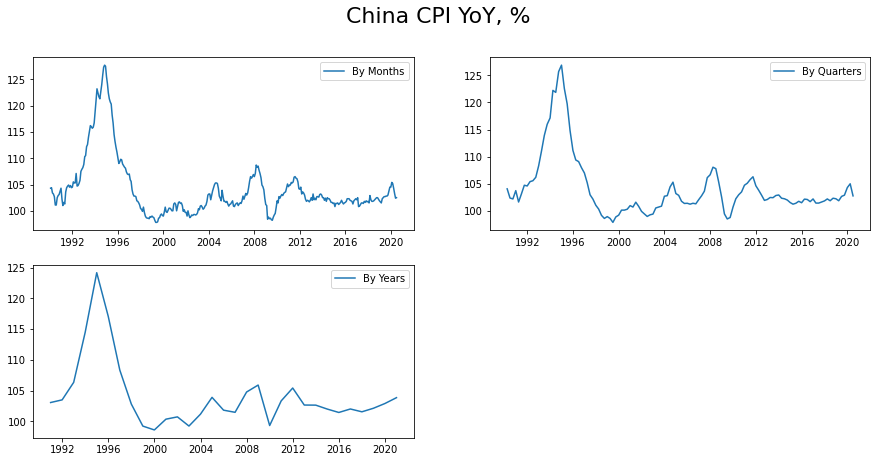

In [ ]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('China CPI YoY, %', fontsize=22)

plt.subplot(221)
plt.plot(df_month.rCPI, '-', label='By Months')
plt.legend()

plt.subplot(222)
plt.plot(df_Q.rCPI, '-', label='By Quarters')
plt.legend()

plt.subplot(223)
plt.plot(df_year.rCPI, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.143359


<Figure size 432x288 with 0 Axes>

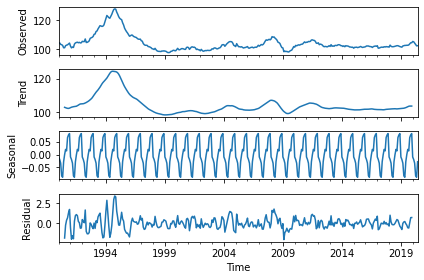

In [ ]:
plt.figure()
sm.tsa.seasonal_decompose(df_month.rCPI).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.rCPI)[1])
plt.show()

**Time Series Forecasting**

Time Series data is an experimental data which has been observed at different points in time (usually evenly spaced, like once a day or once an hour or once a minute). For example, the data of airline ticket sales per day is a time series. However, just because a series of events has a time element does not automatically make it a time series, such as the dates of major airline disasters, which are randomly spaced and are not time series. These types of random processes are known as point process.

Time Series have several key features such as trend, seasonality, and noise.Forecasting is the process of making predictions of the future, based on past and present data. 

Here in this kernel, we attempt to perform Time Series Analysis on the Historic Bitcoin Price data. We can easily see from the **Data Exploration** section, that the Bitcoin prices were quite volatile and inconsistent over the years.  Its very hard to perform Time series analysis on such volatile data. But here we try to explore the different Time series forecasting models. All the models used in this Kernel are very basic, there is scope of more complex and better performing models.  

*  Time Series forecasting with LSTM
* Time Series forecasting with XGBoost
* Time Series forecasting with Facebook Prophet
* Time Series forecasting with ARIMA



**Predicting using LSTM**

In the first section, we use LSTM  (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs [here.](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

For the train and test, we take '25-Jun-2018' as the split date.  There was a considerable dip in Bitcoin prices between the June-July period 2018.  If we check the historical prices the seasonal market started going up from this date after reaching the lowest, though the price reached much lower $5972 on June 29th 2018. After reaching the historic 20K mark on December 18th, there were several dips and market price was recorrected every time. Read more about [Bitcoin dips.](http://https://news.bitcoin.com/data-reveals-reasons-behind-bitcoins-big-dip/)

In [ ]:
# split data
split_date = '2018-01-31'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [ ]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))


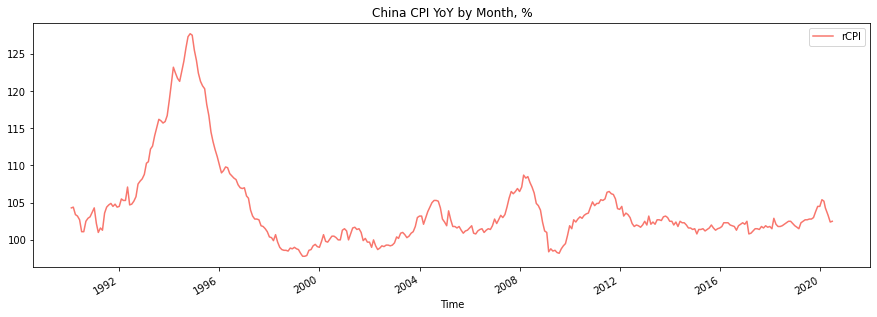

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='China CPI YoY by Month, %')

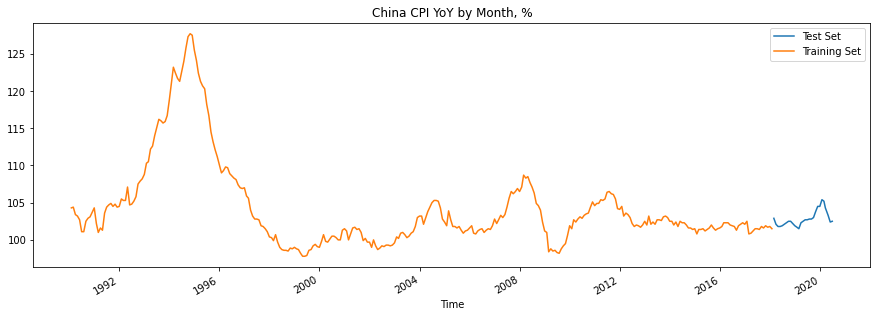

In [ ]:
_ = data_test \
    .rename(columns={'rCPI': 'Test Set'}) \
    .join(data_train.rename(columns={'rCPI': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='China CPI YoY by Month, %', style='')

We will use a Vanilla LSTM here for forecasting. The model is trained on pre 25-Jun-2018 data.

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Using TensorFlow backend.


Epoch 1/100
 - 1s - loss: 0.0766
Epoch 2/100
 - 0s - loss: 0.0820
Epoch 3/100
 - 0s - loss: 0.0712
Epoch 4/100
 - 0s - loss: 0.0619
Epoch 5/100
 - 0s - loss: 0.0697
Epoch 6/100
 - 0s - loss: 0.0606
Epoch 7/100
 - 0s - loss: 0.0765
Epoch 8/100
 - 0s - loss: 0.0676
Epoch 9/100
 - 0s - loss: 0.0613
Epoch 10/100
 - 0s - loss: 0.0659
Epoch 11/100
 - 0s - loss: 0.0641
Epoch 12/100
 - 0s - loss: 0.0644
Epoch 13/100
 - 0s - loss: 0.0608
Epoch 14/100
 - 0s - loss: 0.0512
Epoch 15/100
 - 0s - loss: 0.0595
Epoch 16/100
 - 0s - loss: 0.0586
Epoch 17/100
 - 0s - loss: 0.0540
Epoch 18/100
 - 0s - loss: 0.0567
Epoch 19/100
 - 0s - loss: 0.0557
Epoch 20/100
 - 0s - loss: 0.0526
Epoch 21/100
 - 0s - loss: 0.0500
Epoch 22/100
 - 0s - loss: 0.0504
Epoch 23/100
 - 0s - loss: 0.0459
Epoch 24/100
 - 0s - loss: 0.0432
Epoch 25/100
 - 0s - loss: 0.0496
Epoch 26/100
 - 0s - loss: 0.0431
Epoch 27/100
 - 0s - loss: 0.0413
Epoch 28/100
 - 0s - loss: 0.0531
Epoch 29/100
 - 0s - loss: 0.0388
Epoch 30/100
 - 0s - lo

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_rCPI = model.predict(inputs)
predicted_rCPI = sc.inverse_transform(predicted_rCPI)

In [ ]:
data_test['rCPI_Prediction_lstm'] = predicted_rCPI
data_all = pd.concat([data_test, data_train], sort=False)

In [ ]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'rCPI_Prediction': 'lstm'})
final_data = final_data[['Time','rCPI','lstm']]

KeyError: ignored

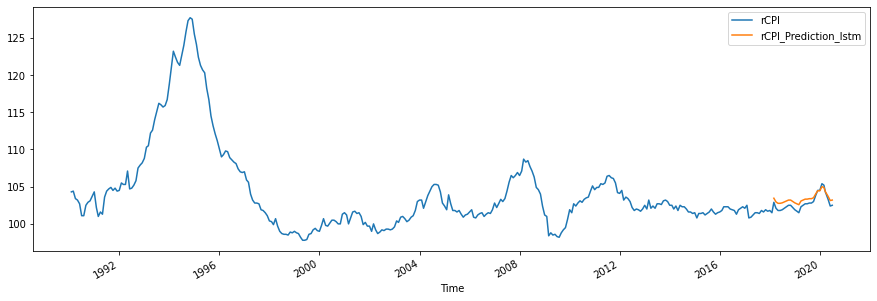

In [ ]:
_ = data_all[['rCPI','rCPI_Prediction_lstm']].plot(figsize=(15, 5))

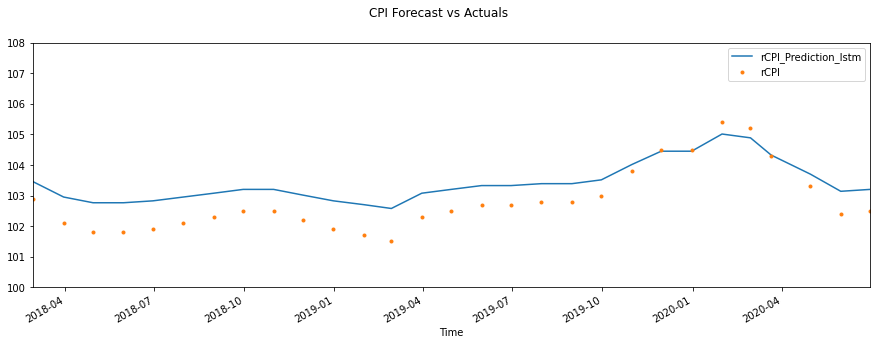

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['rCPI_Prediction_lstm','rCPI']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2018-02-28', upper='2020-06-30')
ax.set_ylim(100, 108)
plot = plt.suptitle('CPI Forecast vs Actuals')

The MSE is 0.48 and MAE is 0.63

In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['rCPI'],
                   y_pred=data_test['rCPI_Prediction_lstm'])

0.48472058946122265

In [ ]:
mean_absolute_error(y_true=data_test['rCPI'],
                   y_pred=data_test['rCPI_Prediction_lstm'])

0.6343766837284487

We can clearly see the entire model is over-fitted. 

**Time Series forecasting with XGBoost**

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. XGBoost is a powerful and versatile tool. Lets see, How well does XGBoost perform when used to predict future values of a time-series like Bitcoin prices ? 

Read more about [XGBoost here.](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    
    X = df[['quarter','month','year',
           'dayofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(data_train, label='rCPI')
X_test, y_test = create_features(data_test, label='rCPI')

Here we use a basic XGBRegressor model,

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, 
                          booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) 

[00:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=10, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
data_test['rCPI_Prediction_xgb'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

In [ ]:
#adding to final data for comparision
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'rCPI_Prediction': 'xgboost'})
final_data = final_data[['Time','rCPI','lstm','xgboost']]

KeyError: ignored

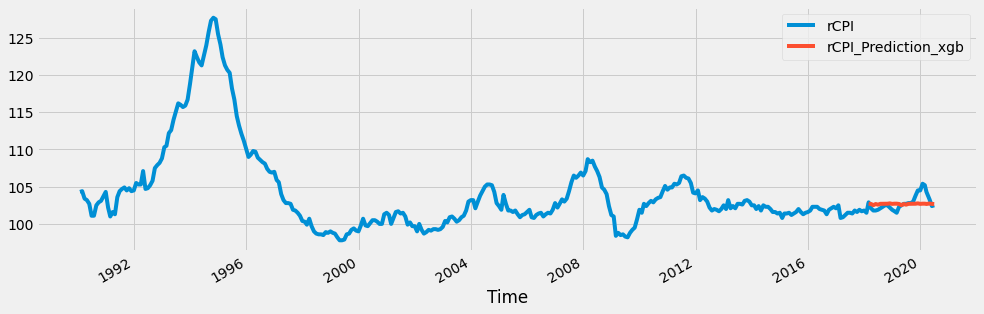

In [ ]:
_ = data_all[['rCPI','rCPI_Prediction_xgb']].plot(figsize=(15, 5))

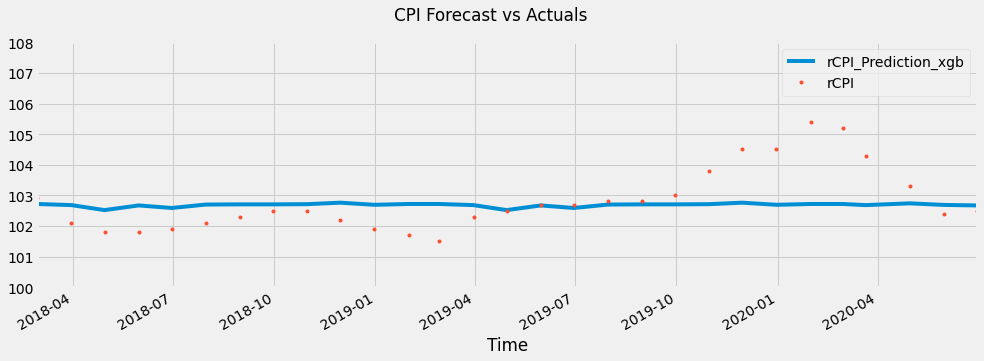

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['rCPI_Prediction_xgb','rCPI']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2018-02-28', upper='2020-06-30')
ax.set_ylim(100, 108)
plot = plt.suptitle('CPI Forecast vs Actuals')

The MSE is 1.04 and MAE is 0.74

In [ ]:
mean_squared_error(y_true=data_test['rCPI'],
                   y_pred=data_test['rCPI_Prediction_xgb'])

1.0457542449980985

In [ ]:
mean_absolute_error(y_true=data_test['rCPI'],
                   y_pred=data_test['rCPI_Prediction_xgb'])

0.7420798466123386

**Time Series forecasting with Prophet**

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. Refer [Prophet here.](https://facebook.github.io/prophet/)

The Prophet package provides intuitive parameters which are easy to tune. Even someone with minimum expertise in forecasting models can use this to make meaningful predictions for a variety of problems in a business scenario.





In [ ]:
data_train = data_train.reset_index().rename(columns={'Time':'ds', 'rCPI':'y'})

In [ ]:
# Setup and train model
model = Prophet()
model.fit(data_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
model = Prophet()
model.fit(data_train)
data_test_fcst = model.predict(df=data_test.reset_index().rename(columns={'Time':'ds'}))

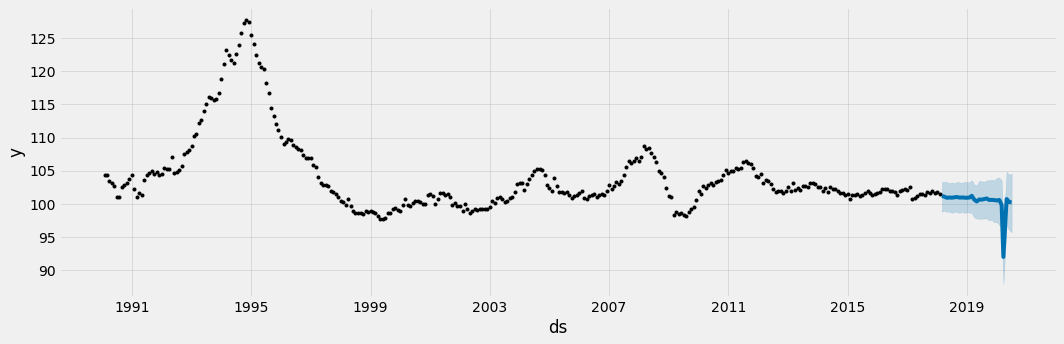

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(data_test_fcst, ax=ax)

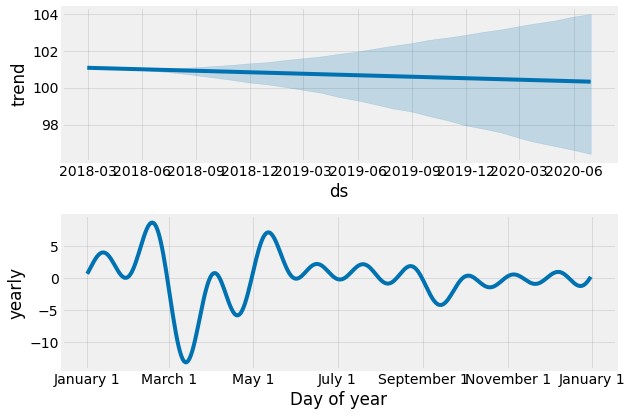

In [ ]:
# Plot the components
fig = model.plot_components(data_test_fcst)

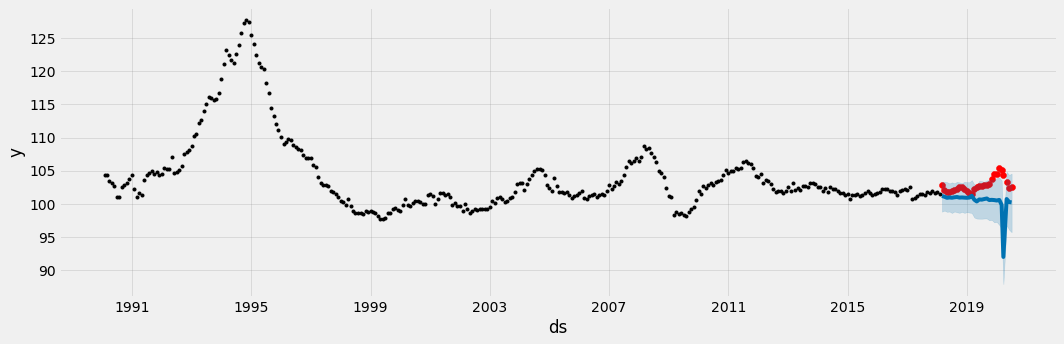

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['rCPI'], color='r')
fig = model.plot(data_test_fcst, ax=ax)

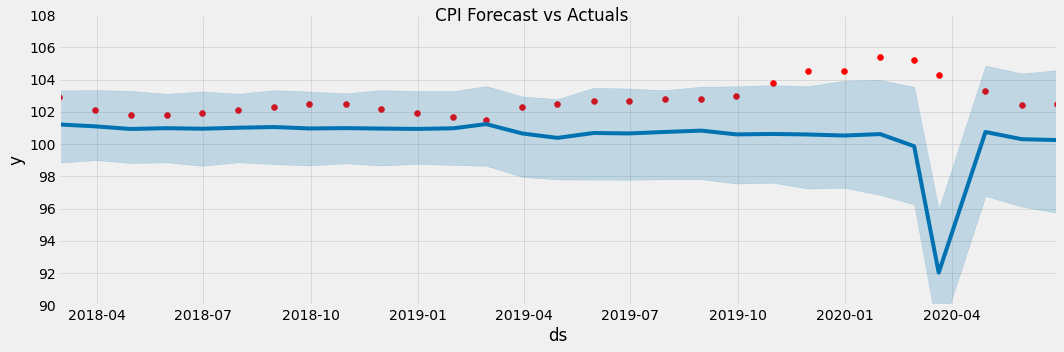

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['rCPI'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
ax.set_xbound(lower=pd.Timestamp('2018-02-28'), upper=pd.Timestamp('2020-06-30'))
ax.set_ylim(90, 108)
plot = plt.suptitle('CPI Forecast vs Actuals')

The MSE is 10.52 and MAE is 2.36

In [ ]:
mean_squared_error(y_true=data_test['rCPI'],
                   y_pred=data_test_fcst['yhat'])

10.518018716546239

In [ ]:
mean_absolute_error(y_true=data_test['rCPI'],
                   y_pred=data_test_fcst['yhat'])

2.361359110868145

In [ ]:
data_test['rCPI_Prediction_ppt']= np.array(data_test_fcst['yhat'])

**LSTM , XGBoost and Prophet - How good are they ?**

Here lets visualize and compare the predictive results of LSTM, XGBoost and Prophet in a single plot,

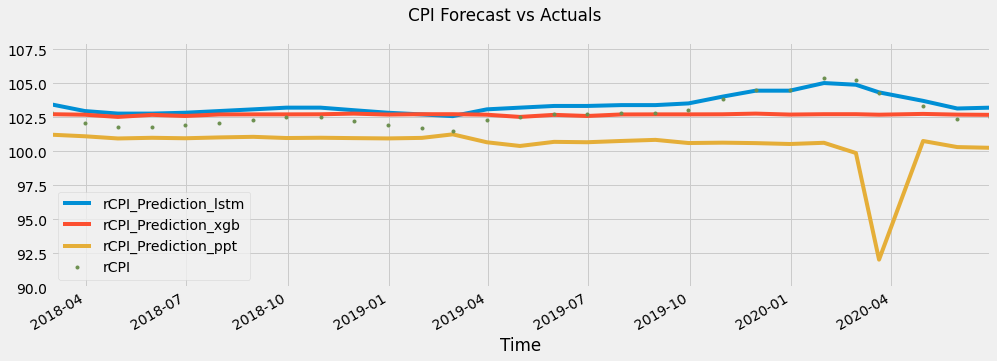

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_test[['rCPI_Prediction_lstm','rCPI_Prediction_xgb','rCPI_Prediction_ppt','rCPI']].plot(ax=ax,
                                              style=['-','-','-','.'])
ax.set_xbound(lower='2018-02-28', upper='2020-06-30')
ax.set_ylim(90, 108)
plot = plt.suptitle('CPI Forecast vs Actuals')

**Time Series forecasting using ARIMA**

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.
This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:
* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA is one of the mostly used techniques for Time Series analysis. In Python,  ARIMA based forecasting models can be created either using AutoARIMA[(Pyramid ARIMA)](https://pypi.org/project/pyramid-arima/) or [StatsModel ](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html). Here we will be using StatsModel as Kaggle do not support Pyramid ARIMA till now.

In [ ]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

In previous sections of LSTM,XGBoost and Prophet, we used hourly data to train the model. But here we will use the monthly data (for Seasonality).

Decomposition

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving China_Monthly_CPI.csv to China_Monthly_CPI.csv


In [ ]:
import io
df= pd.read_csv(io.BytesIO(uploaded['China_Monthly_CPI.csv'])) 

In [ ]:
df.rCPI=df.rCPI+100
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

In [ ]:
df_month = df.resample('M').mean()

Dickey–Fuller test: p=0.143359


<Figure size 1080x504 with 0 Axes>

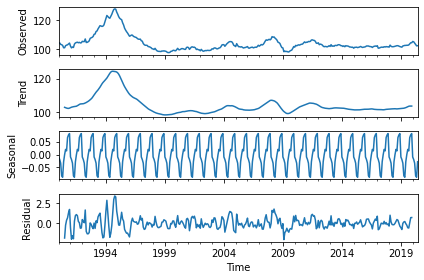

In [ ]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.rCPI).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.rCPI)[1])
plt.show()

In [ ]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.rCPI)[1])

Dickey–Fuller test: p=0.143359


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



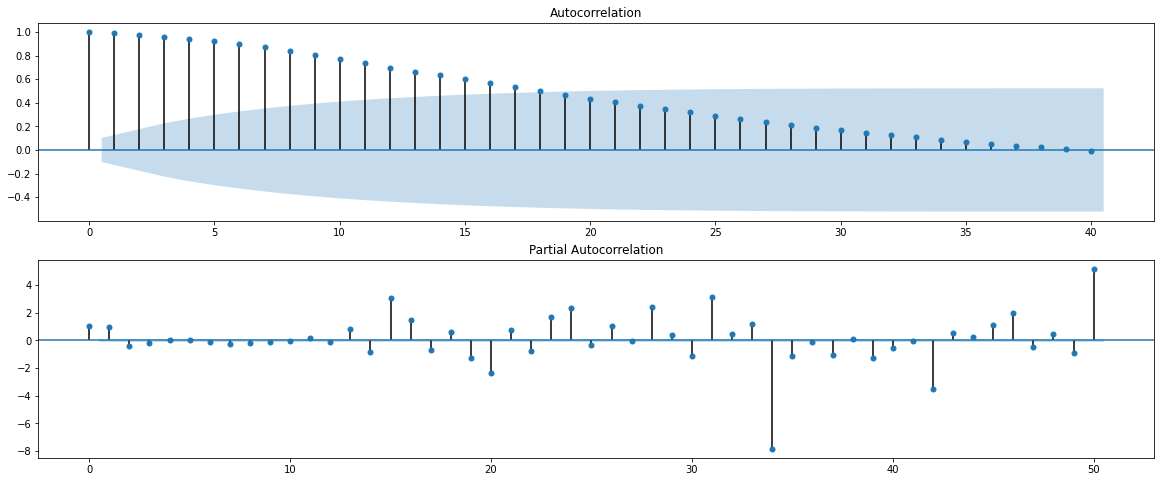

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(df_month.rCPI, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(df_month.rCPI, ax=pyplot.gca(), lags=50)
pyplot.show()

Here's the Statespace ARIMA Model, the best model is selected using different parameters.

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.rCPI, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
47  (2, 1, 2, 1)  596.381824
53  (2, 2, 2, 1)  597.558124
35  (1, 2, 2, 1)  599.188978
29  (1, 1, 2, 1)  601.133599
41  (2, 0, 2, 1)  618.167963
                                 Statespace Model Results                                 
Dep. Variable:                               rCPI   No. Observations:                  366
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -291.191
Date:                            Thu, 30 Jul 2020   AIC                            596.382
Time:                                    20:43:38   BIC                            622.912
Sample:                                01-31-1990   HQIC                           606.968
                                     - 06-30-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000680


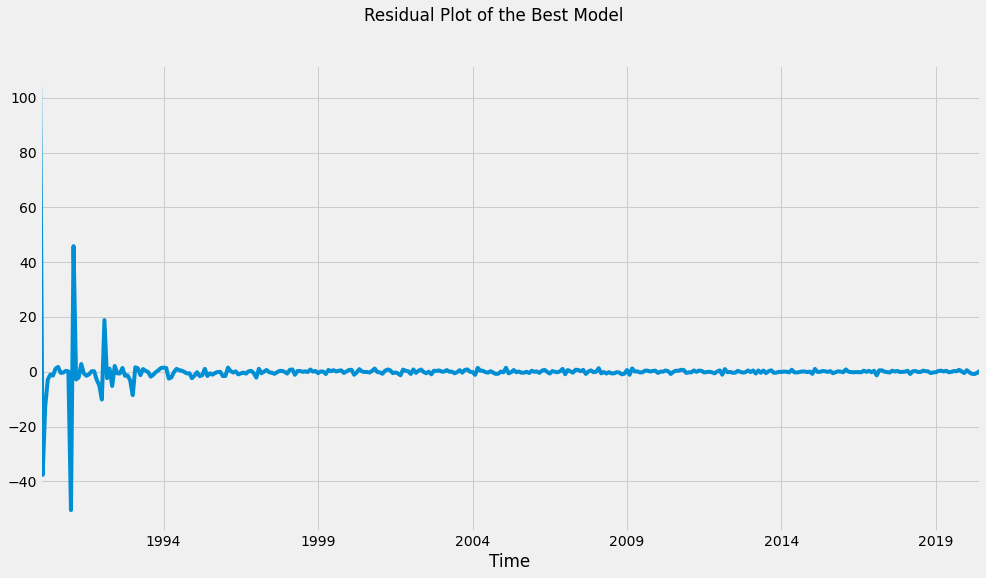

In [ ]:
fig = plt.figure(figsize=(15,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

In [ ]:
df_month.head()

,rCPI
Time,
1990-01-31,104.3
1990-02-28,104.4
1990-03-31,103.4
1990-04-30,103.2
1990-05-31,102.7


In [ ]:
df_month2 = pd.DataFrame(df_month.rCPI[337:])

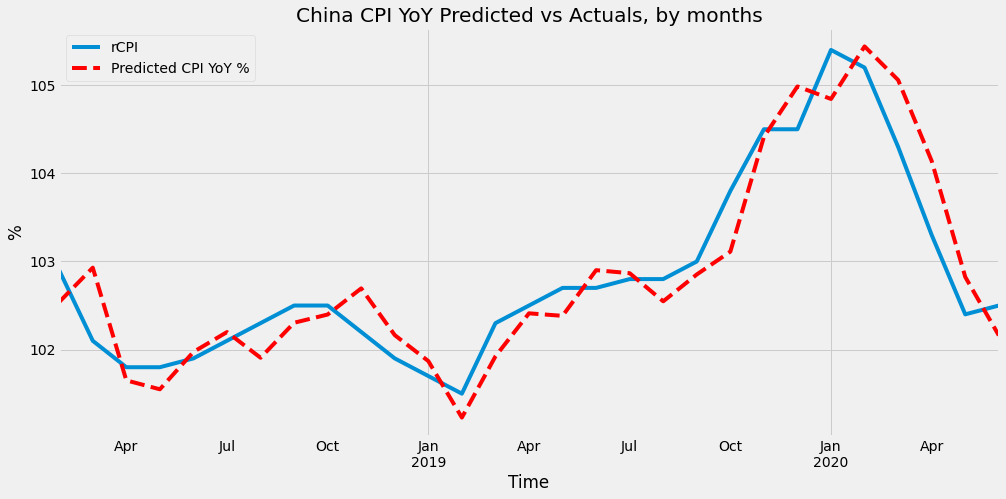

In [ ]:
#df_month2 = df_month[['rCPI']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=337, end=380)
plt.figure(figsize=(15,7))
df_month2.rCPI.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted CPI YoY %')
plt.legend()
plt.title('China CPI YoY Predicted vs Actuals, by months')
plt.ylabel('%')
plt.show()

The MSE is 0.15 and MAE is 0.32

In [ ]:
split_date = '2018-01-31'
test=df_month2.loc[df_month2.index>split_date].copy()
mean_squared_error(y_true=test.rCPI,
                   y_pred=test.forecast)

0.15788701880290595

In [ ]:
mean_absolute_error(y_true=test.rCPI,
                   y_pred=test.forecast)

0.32827644897212666

In [ ]:
data_test['rCPI_Prediction_ARIMA']=test.forecast

In [ ]:
data_test.rCPI_Prediction_ARIMA[-4]=105.058820

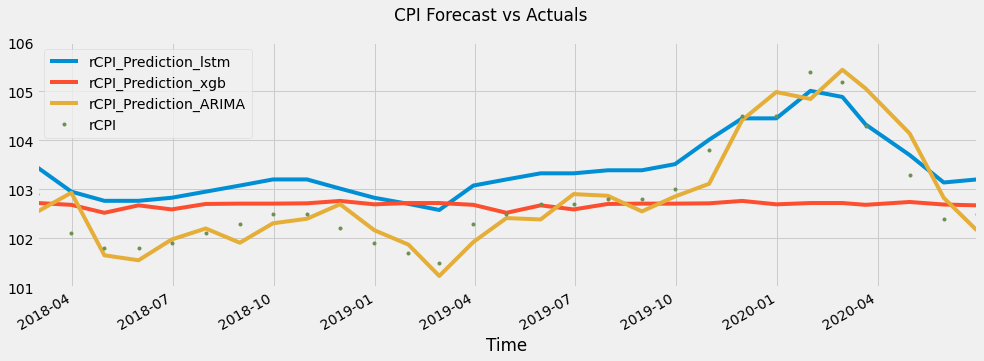

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_test[['rCPI_Prediction_lstm','rCPI_Prediction_xgb','rCPI_Prediction_ARIMA','rCPI']].plot(ax=ax,
                                              style=['-','-','-','.'])
ax.set_xbound(lower='2018-02-28', upper='2020-06-30')
ax.set_ylim(101, 106)
plot = plt.suptitle('CPI Forecast vs Actuals')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_preds_custom.csv to test_preds_custom.csv


In [ ]:
import io
df= pd.read_csv(io.BytesIO(uploaded['test_preds_custom.csv'])) 

In [ ]:
df.head()

,Time,rCPI (actual),rCPI (pred)
0,2/28/2018,102.9,102.382759
1,3/31/2018,102.1,102.176956
2,4/30/2018,101.8,101.963448
3,5/31/2018,101.8,102.127792
4,6/30/2018,101.9,102.070106


In [ ]:
data_test['rCPI_Prediction_H2O']=np.array(df['rCPI (pred)'])

In [ ]:
data_test.head()

,rCPI,rCPI_Prediction_lstm,date,quarter,month,year,dayofyear,rCPI_Prediction_xgb,rCPI_Prediction_ppt,rCPI_Prediction_ARIMA,rCPI_Prediction_H2O
Time,,,,,,,,,,,
2018-02-28,102.9,103.450081,2018-02-28,1,2,2018,59,102.718750,101.213287,102.539665,102.382759
2018-03-31,102.1,102.950981,2018-03-31,1,3,2018,90,102.681778,101.096106,102.929303,102.176956
2018-04-30,101.8,102.763840,2018-04-30,2,4,2018,120,102.518959,100.934699,101.650684,101.963448
2018-05-31,101.8,102.763840,2018-05-31,2,5,2018,151,102.671463,100.984318,101.549577,102.127792
2018-06-30,101.9,102.826218,2018-06-30,2,6,2018,181,102.588005,100.949645,101.973362,102.070106


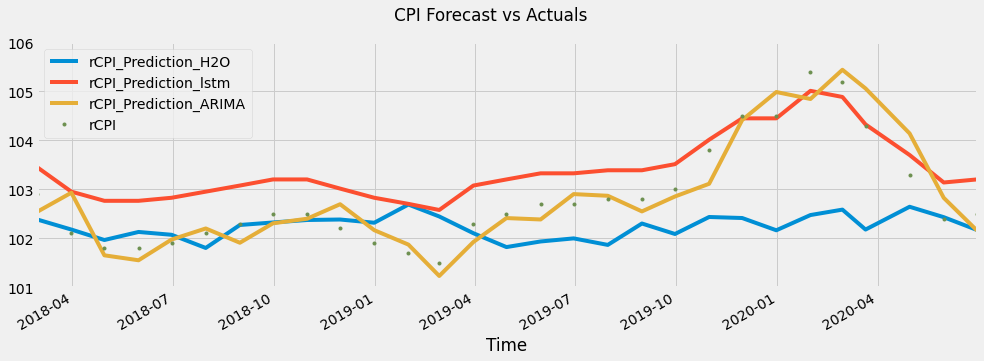

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_test[['rCPI_Prediction_H2O','rCPI_Prediction_lstm','rCPI_Prediction_ARIMA','rCPI']].plot(ax=ax,
                                              style=['-','-','-','.'])
ax.set_xbound(lower='2018-02-28', upper='2020-06-30')
ax.set_ylim(101, 106)
plot = plt.suptitle('CPI Forecast vs Actuals')